In [18]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
from torch_geometric.data import Data
from net import SegmentationNet, WrapSegmentationNet
from net import ClassifierNet
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('/data/rradev/supernovae_trigger/outputs/wrapper_net_epoch4_acc_0.94.pth')
num_hits = 100
num_classes = 2
model = WrapSegmentationNet(num_hits, 2, num_classes).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
pos = torch.randn(100, 7)
node_label = torch.randn(100)
label = torch.randn(100)
batch = Data(
    x=node_label,
    y=label,
    pos=pos.to(torch.float)).to(device)
model.eval()

WrapSegmentationNet(
  (segmentation_network): SegmentationNet(
    (conv1): DynamicEdgeConv(nn=MLP(14, 64, 64), k=30)
    (conv2): DynamicEdgeConv(nn=MLP(128, 64, 64), k=30)
    (conv3): DynamicEdgeConv(nn=MLP(128, 64, 64), k=30)
    (mlp): MLP(192, 1024, 256, 128, 2)
  )
  (mlp): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [21]:
def split_string(string): 
    return float(string.split(":,",1)[1][:])

def detach_tensor(tensor):
    return tensor.cpu().detach().numpy()

def parse_log(logfile):
    train_acc = []
    test_acc = []
    with open(logfile) as f:
        lines = f.readlines()


    for line in lines:
        if 'Current train acc:' in line:
            train_acc.append(split_string(line))
        if 'Current test acc' in line:
            test_acc.append(split_string(line))
    return train_acc, test_acc

def plot_metric(metric, label):
    plt.plot(np.arange(len(metric)), metric, label=label)
    
    
def plot_logfile(logfile, training_label=''):
    train_acc, test_acc = parse_log(logfile)
    plot_metric(train_acc, label=f'{training_label}_train')
    plot_metric(test_acc, label=f'{training_label}_test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')


In [3]:
# plt.rcParams['figure.figsize'] = (8, 4)
# log_folder = '/data/rradev/supernovae_trigger/log/'
# logfile = 'segment_2022-11-22_16-18-14_296928.log'

# plot_logfile(log_folder + logfile, '100hits')
# plt.legend()


### Compute Classification Report

In [61]:
#Dataloader
data_dir = '/eos/user/p/pbarhama/graphnns/saved_pickles/np_arrays/'
train_file = 'test_events_100_1_aronly.npz'
path = data_dir + train_file
test_tensor = torch.tensor(np.load(path)['test']).to(device)
op_channel, peak_time, x, y, z, width, area, amplitude, pe, node_labels, labels = torch.transpose(test_tensor, 2, 0)
test_ds = torch.stack([peak_time, x, y, z, width, amplitude, pe], dim=2).to(torch.float).swapaxes(0, 1)

In [62]:
test_ds.shape

torch.Size([14289, 100, 7])

In [63]:
def test(loader, batch_size=1):
    preds = []
    model.eval()
    for data in tqdm(loader):
        batch = Data(
            pos=data.to(torch.float))
        batch = batch.to(device)
        with torch.no_grad():
            pred = model(batch, batch_size)
            preds.append(pred)
    return detach_tensor(torch.vstack(preds)), np.argmax(detach_tensor(torch.vstack(preds)), axis=1)

probas, preds = test(test_ds)

100%|██████████| 14289/14289 [01:47<00:00, 133.25it/s]


In [37]:
event_labels = np.greater(node_labels.sum(dim=1).cpu().numpy(), 0).astype(np.int32)
np.all(event_labels == labels.cpu().numpy())

True

In [64]:
probas

array([[-9.1679642e+01,  0.0000000e+00],
       [-6.5744840e-02, -2.7546661e+00],
       [-4.6079718e-02, -3.1003346e+00],
       ...,
       [-2.2605884e+00, -1.1013752e-01],
       [-1.0882907e-01, -2.2718973e+00],
       [-2.1616533e+01,  0.0000000e+00]], dtype=float32)

In [65]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(event_labels, preds, normalize='true')
conf_matrix = np.round(conf_matrix, 3)

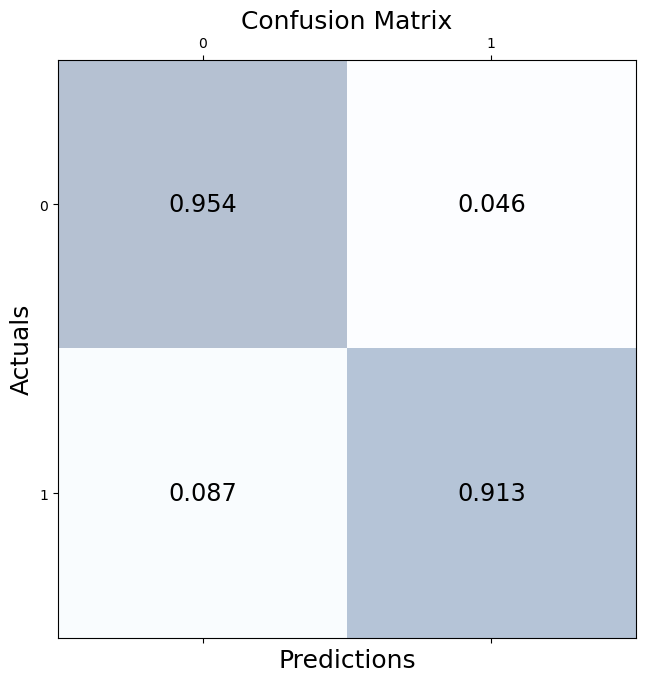

In [66]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

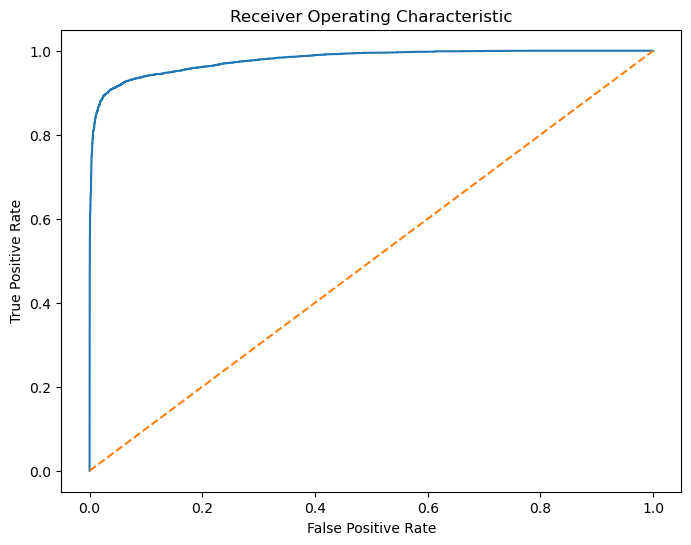

In [68]:
from sklearn.metrics import roc_curve

fp_rate, tp_rate, threshold = roc_curve((event_labels).astype(float), probas[:, 1])

plt.subplots(1, figsize=(8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fp_rate, tp_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

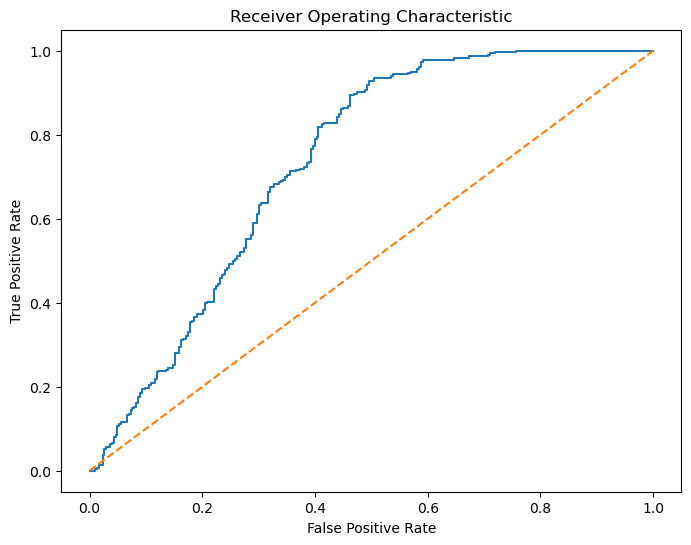

In [90]:
from sklearn.metrics import roc_auc_score

def hits_score(n_hits, probas, labels, node_labels):
    sg_indices = node_labels.ravel() == n_hits
    sg_probas = probas[:, 1][sg_indices]
    sg_labels = labels[sg_indices]

    bg_labels = labels[labels == 0]
    bg_probas = probas[:, 1][labels == 0]
    bg_indices = np.random.choice(
        np.arange(len(bg_labels)), size=len(sg_labels)
    )
    bg_labels = bg_labels[bg_indices]
    bg_probas = bg_probas[bg_indices]

    sample_labels = np.hstack((sg_labels, bg_labels))
    sample_probas = np.hstack((sg_probas, bg_probas))
    return sample_labels, sample_probas

def hits_roc_curve(n_hits, probas, labels, node_labels  ):
    sample_labels, sample_probas = hits_score(n_hits, probas, labels, node_labels)
    return roc_curve(sample_labels, sample_probas)

def hits_auc_score(n_hits, probas, labels, node_labels):
    sample_labels, sample_probas = hits_score(n_hits, probas, labels, node_labels)
    return roc_auc_score(sample_labels, sample_probas)

fp_rate, tp_rate, _ = hits_roc_curve(1, probas, event_labels.astype(float), detach_tensor(node_labels.sum(dim=0)))

def plot_roc(fp_rate, tp_rate):
    plt.subplots(1, figsize=(8, 6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp_rate, tp_rate)
    plt.plot([0, 1], ls="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_roc(fp_rate, tp_rate)

In [96]:
import pickle

hits_rates = {}
for n_hits in range(10, 50):
    fp_rate, tp_rate, _ = hits_roc_curve(n_hits, probas, event_labels.astype(float), detach_tensor(node_labels.sum(dim=0)))
    rates = {'fp_rate': fp_rate, 'tp_rate': tp_rate}
    hits_rates[f'n_hits_{n_hits}'] = rates

with open("100_hits_sample_fp_tp_rates.pcl","wb") as f:
    pickle.dump(hits_rates, f)

Text(0.5, 0, 'n hits')

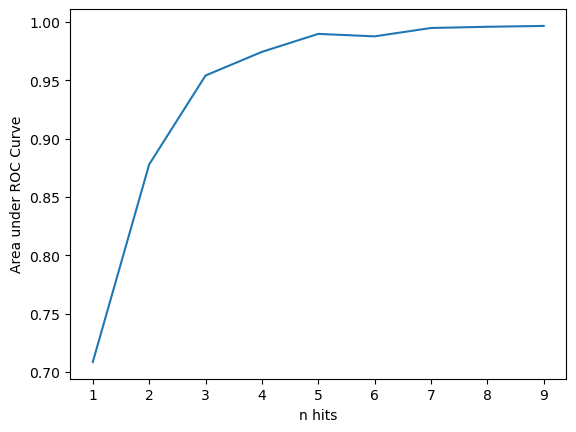

In [98]:
n_hits = list(range(1, 10))
auc_scores = [hits_auc_score(n, probas, event_labels, detach_tensor(node_labels.sum(dim=0))) for n in n_hits]
plt.plot(n_hits, auc_scores)
plt.ylabel('Area under ROC Curve')
plt.xlabel('n hits')